Спасибо за помощь, Вера

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import timedelta

import warnings
warnings.filterwarnings('ignore')

#отобразить большие числа без плавающей точки
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Описание проекта

Задание от отдела маркетинговой аналитики Яндекс.Афиши.  
Первое задание: помочь маркетологам снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет.

Есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

Вам предстоит изучить:
- как клиенты пользуются сервисом,
- когда делают первые покупки на сайте,
- сколько денег приносит компании каждый клиент,
- когда расходы на привлечение клиента окупаются.

Выручка измеряется в условных единицах — у.е.

Рассчитайте метрики и постройте графики
Посчитайте метрики трёх видов:
- продуктовые,
- метрики электронной коммерции,
- маркетинговые.  
Отобразите на графиках изменения каждой метрики во времени. Всякий раз старайтесь подобрать наиболее подходящий тип визуализации: в некоторых случаях может быть уместна тепловая карта когортного анализа.
После каждого пункта сформулируйте выводы.

# Цель исследование
- Определите источники трафика, на которые маркетологам стоит делать упор. Объясните свой выбор: на какие метрики вы ориентируетесь и почему;  
- Опишите выводы, которые вы сделали после подсчёта метрик каждого вида: маркетинговых, продуктовых и метрик электронной коммерции;  
- Подведите итоги когортного анализа. Определите самые перспективные для компании когорты клиентов;

## Предобработка данных

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [3]:
#Функция для вывода основных данных о предоставленном датафрейме, шапка, количество пропусков
def dataframe_info(df):
    print('Информация о колонках\n')
    print(df.info())
    
    print('\nШапка таблицы')
    print(df.head(2))
    
    print('\nКоличество пропусков в колонках')
    display(pd.DataFrame(df.isnull().sum()))
    
    return

### Предобработка данных посещение сайта

Структура visits_log.csv
- Uid — уникальный идентификатор пользователя,
- Device — категория устройства пользователя,
- Start Ts — дата и время начала сессии,
- End Ts — дата и время окончания сессии,
- Source Id — идентификатор источника перехода на сайт.

In [4]:
dataframe_info(visits)

Информация о колонках

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
None

Шапка таблицы
    Device               End Ts  Source Id             Start Ts  \
0    touch  2017-12-20 17:38:00          4  2017-12-20 17:20:00   
1  desktop  2018-02-19 17:21:00          2  2018-02-19 16:53:00   

                    Uid  
0  16879256277535980062  
1    104060357244891740  

Количество пропусков в колонках


,0
Device,0
End Ts,0
Source Id,0
Start Ts,0
Uid,0


Пропусков нет, в шапке таблицы используються заглавные буквы, Нужно поменять тип данных Start Ts, End Ts

In [5]:
visits.columns = visits.columns.str.lower()

In [6]:
visits.set_axis(['device','end_ts','source_id','start_ts','uid'], axis = 'columns', inplace = True)

In [7]:
visits.head()

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


Изменение типов данных

In [8]:
visits['source_id'].unique()

array([ 4,  2,  5,  9,  3,  1, 10,  7,  6])

В колонке source_id значения небольшие можно изменить тип данных int8

In [9]:
visits['source_id'] = visits['source_id'].astype('int8')

In [10]:
visits['source_id'].dtypes

dtype('int8')

Всего источники посещения в отдельной переменной

In [11]:
sources = visits['source_id'].unique()
sources.sort()
sources

array([ 1,  2,  3,  4,  5,  6,  7,  9, 10])

Изменение колонки с датами со строки на дату

In [12]:
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
visits['end_ts'] = pd.to_datetime(visits['end_ts'])

In [13]:
visits['start_ts'] = pd.to_datetime(visits['start_ts'])

Получение информации о первом посещении

In [14]:
visits.head()

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [15]:
#visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid', 'visit_month', 'first_visit_source', 'first_visit_month']

device_visit['first_visit_month'].describe()

### Предобработка данных информацию о заказах

In [16]:
dataframe_info(orders)

Информация о колонках

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
None

Шапка таблицы
                Buy Ts  Revenue                   Uid
0  2017-06-01 00:10:00    17.00  10329302124590727494
1  2017-06-01 00:25:00     0.55  11627257723692907447

Количество пропусков в колонках


,0
Buy Ts,0
Revenue,0
Uid,0


In [17]:
orders.columns = orders.columns.str.lower()

In [18]:
orders.set_axis(['buy_ts','revenue','uid'], axis = 'columns', inplace = True)

In [19]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

In [20]:
orders.head(1)

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494


### Предобработка данных о расходах на маркетинг

In [21]:
dataframe_info(costs)

Информация о колонках

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
None

Шапка таблицы
   source_id          dt  costs
0          1  2017-06-01  75.20
1          1  2017-06-02  62.25

Количество пропусков в колонках


,0
source_id,0
dt,0
costs,0


In [22]:
costs.set_axis(['source_id','dt','costs'], axis = 'columns', inplace = True)

In [23]:
costs['source_id'].unique()

array([ 1,  2,  3,  4,  5,  9, 10])

В колонке source_id таблицы заказов также можно поменять тип формата для уменьшение размеров тетради

In [24]:
costs['source_id'] = costs['source_id'].astype('int8')

In [25]:
costs['date'] = pd.to_datetime(costs['dt'])

**Проверка на дубли**

In [26]:
print('Всего дубликатов в visits', visits.duplicated().sum())

Всего дубликатов в visits 0


In [27]:
print('Всего дубликатов в orders', orders.duplicated().sum())

Всего дубликатов в orders 0


In [28]:
print('Всего дубликатов в costs', costs.duplicated().sum())

Всего дубликатов в costs 0


## Формирование когорт

Рост продаж, рост затрат; Количество уникальных пользователей, Как часто пользователи пользуються сервисом; Какие девайсы используються; Основная платформа пользователей которые делают заказ; Влияние рекламы на заказы пользователей; Количество заходов пользователей... Какие девайсы используються при покупки

In [29]:
visits['device'].unique()

array(['touch', 'desktop'], dtype=object)

In [30]:
visits.groupby('device')['uid'].count()

device
desktop    262567
touch       96833
Name: uid, dtype: int64

Фрейм посещение сайта

In [31]:
visits['visit_month'] = visits['start_ts'].astype('datetime64[M]')
first_visit = visits.groupby('uid').agg({'visit_month': 'min'}).reset_index()
#first_visit.columns = ['uid', 'first_visit_month']
first_visit.columns = ['uid', 'visit_month']
#first_visit.head()
first_source_visit = pd.merge(first_visit, visits[['source_id','uid', 'visit_month']],
                       how='left', on=['uid', 'visit_month'])
first_source_visit.columns = ['uid', 'first_visit_month', 'first_visit_source']
first_source_visit.head()

,uid,first_visit_month,first_visit_source
0,11863502262781,2018-03-01,3
1,49537067089222,2018-02-01,2
2,297729379853735,2017-06-01,3
3,313578113262317,2017-09-01,2
4,325320750514679,2017-09-01,5


In [32]:
visits = pd.merge(visits, first_source_visit[['first_visit_source', 'uid', 'first_visit_month']], on='uid')

Фрейм заказы

In [33]:
orders = pd.merge(orders, first_source_visit[['first_visit_source', 'uid', 'first_visit_month']], on='uid')

In [34]:
orders.head()

,buy_ts,revenue,uid,first_visit_source,first_visit_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,1,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,3,2017-06-01


Фрейм затраты источник и дата есть

In [35]:
costs.head()

,source_id,dt,costs,date
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-02
2,1,2017-06-03,36.53,2017-06-03
3,1,2017-06-04,55.00,2017-06-04
4,1,2017-06-05,57.08,2017-06-05


## Расчет метрик

### Продуктовые метрики

#### Пользовательская активность

- DAU (от англ. daily active users) — количество уникальных пользователей в день;
- WAU (от англ. weekly active users) — количество уникальных пользователей в неделю;
- MAU (от англ. monthly active users) — количество уникальных пользователей в месяц.

In [37]:
#месячные пользователи за весь период
mau_group = (
    visits_m.groupby(['session_year', 'session_month'])
    .agg({'uid': 'nunique'})
    
)

#дневные  пользователи 
dau_group = visits_m.groupby('session_date').agg({'uid': 'nunique'})

#недельные пользователи в месяц
wau_group = (
    visits_m.groupby(['session_year', 'session_week'])
    .agg({'uid': 'nunique'})
    
)

In [38]:
print('Количество уникальных пользователей в месяц',int(mau_group.mean()))
print('Количество уникальных пользователей в неделю',int(wau_group.mean()))
print('Количество уникальных пользователей в день',int(dau_group.mean()))

Количество уникальных пользователей в месяц 23228
Количество уникальных пользователей в неделю 5716
Количество уникальных пользователей в день 907


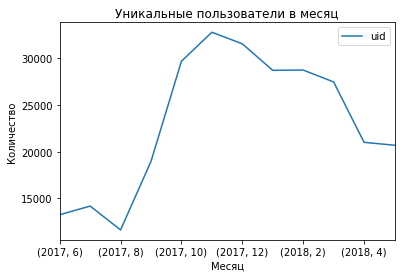

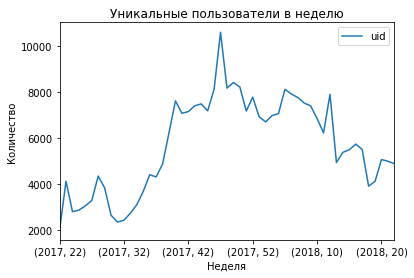

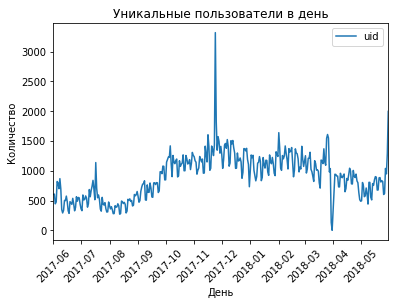

In [39]:
mau_group.plot()
plt.xlabel('Месяц')
plt.ylabel('Количество')
plt.title('Уникальные пользователи в месяц')

wau_group.plot()
plt.xlabel('Неделя')
plt.ylabel('Количество')
plt.title('Уникальные пользователи в неделю')

dau_group.plot()
plt.xlabel('День')
plt.title('Уникальные пользователи в день')
plt.xticks(rotation = 45)
plt.ylabel('Количество')
plt.show()

Ожидаемо количество пользователей к концу году растет и после нового года постепенно падает. Апрель резкое падение пользователей чем обясняеться?

#### Cколько раз за день пользователи в среднем заходят на сайт

In [40]:
dau_group_mean = visits_m.groupby('session_date')['uid'].count()

In [41]:
dau_group_mean.head()

session_date
2017-06-01    1805
2017-06-02    1891
2017-06-03    1359
2017-06-04    1315
2017-06-05    2489
Name: uid, dtype: int64

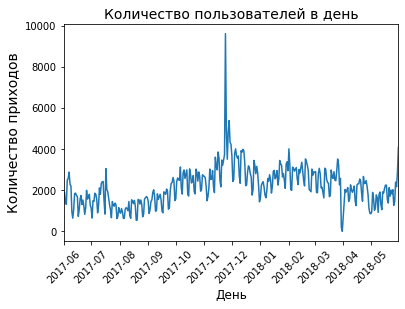

In [42]:
dau_group_mean.plot()
plt.xlabel('День', fontsize=12)
plt.title('Количество пользователей в день', fontsize=14)
plt.xticks(rotation = 45)
plt.ylabel('Количество приходов', fontsize=14)
plt.show()

#### Cколько времени пользователи проводят на сайте

In [43]:
visits.head()

,device,end_ts,source_id,start_ts,uid,visit_month,first_visit_source,first_visit_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,4,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01,2,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,5,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-01,4,2018-03-01
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-01,4,2018-03-01


In [44]:
visits['dif_date'] = visits['end_ts'] - visits['start_ts']

In [45]:
visits['dif_date'].head()

0   00:18:00
1   00:28:00
2   00:00:00
3   00:24:00
4   00:28:00
Name: dif_date, dtype: timedelta64[ns]

In [46]:
visits['dif_date1'] = visits['dif_date'] / np.timedelta64(1, 'm')
visits['dif_date1'].head()

0   18.00
1   28.00
2    0.00
3   24.00
4   28.00
Name: dif_date1, dtype: float64

In [47]:
visits['dif_date'] = visits['dif_date'].dt.total_seconds() // 60

In [48]:
visits['dif_date1'].describe()

count   792914.00
mean        17.14
std         27.47
min        -46.00
25%          2.00
50%          8.00
75%         22.00
max        711.00
Name: dif_date1, dtype: float64

Text(0.5, 0, 'Афиша')

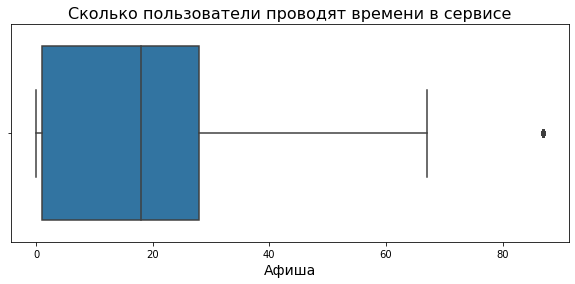

In [49]:
plt.figure(figsize=(10,4))
boxplot = sns.boxplot( visits['dif_date1'] , data = visits['dif_date1'] )
boxplot.axes.set_title("Сколько пользователи проводят времени в сервисе", fontsize=16)
boxplot.set_xlabel("Афиша", fontsize=14)
#boxplot.set_ylabel("Количество", fontsize=14)

В среднем пользоватеи проводят на сервисе около 20 минут, максимум 30 минут.

In [50]:
visits.loc[visits['dif_date1']>1].head()

,device,end_ts,source_id,start_ts,uid,visit_month,first_visit_source,first_visit_month,dif_date,dif_date1
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,4,2017-12-01,18.00,18.00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01,2,2018-02-01,28.00,28.00
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-01,4,2018-03-01,24.00,24.00
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-01,4,2018-03-01,28.00,28.00
12,desktop,2017-10-27 16:02:00,3,2017-10-27 15:20:00,16007536194108375387,2017-10-01,5,2017-09-01,42.00,42.00


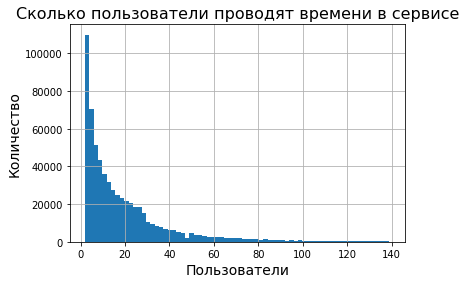

In [51]:
visits['dif_date'].loc[(visits['dif_date']> 1 ) & (visits['dif_date'] < 140)].hist(bins=70)
plt.xlabel('Пользователи', fontsize=14)
plt.title('Сколько пользователи проводят времени в сервисе', fontsize=16)
plt.ylabel('Количество', fontsize=14)
plt.show()

Левое распределение, много заходов в сервис на несколько минут

In [52]:
visits.loc[visits['dif_date1']<0][['start_ts', 'end_ts',   'dif_date', 'dif_date1']].head()

,start_ts,end_ts,dif_date,dif_date1
270606,2018-03-25 03:50:00,2018-03-25 03:18:00,-33.00,-32.00
270607,2018-03-25 03:50:00,2018-03-25 03:18:00,-33.00,-32.00
270608,2018-03-25 03:50:00,2018-03-25 03:18:00,-33.00,-32.00
270609,2018-03-25 03:50:00,2018-03-25 03:18:00,-33.00,-32.00
270610,2018-03-25 03:50:00,2018-03-25 03:18:00,-33.00,-32.00


Много сесий с окончанием раньше начало

много пользователей проводит несколько минут, 

In [53]:
visits['dif_date'].describe()

count   792914.00
mean        17.14
std         27.47
min        -46.00
25%          2.00
50%          8.00
75%         22.00
max        711.00
Name: dif_date, dtype: float64

In [54]:
visits['dif_date'].median()

8.0

In [55]:
visits['dif_date'].mode()

0   1.00
dtype: float64

<div class="alert alert-info"> 
Буду использовать медиану. Средняя длительность у нас 8 минут 
    </div>

#### Рассчет Retention Rate, применяя когортный анализ.

Недельная когорта

In [56]:
visits.head()

,device,end_ts,source_id,start_ts,uid,visit_month,first_visit_source,first_visit_month,dif_date,dif_date1
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,4,2017-12-01,18.00,18.00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01,2,2018-02-01,28.00,28.00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,5,2017-07-01,0.00,0.00
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-01,4,2018-03-01,24.00,24.00
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-01,4,2018-03-01,28.00,28.00


In [57]:
#формирование когорт
cohorts = visits[['start_ts', 'end_ts', 'uid', 'first_visit_month', 'first_visit_source']]

In [58]:
cohorts.head()

,start_ts,end_ts,uid,first_visit_month,first_visit_source
0,2017-12-20 17:20:00,2017-12-20 17:38:00,16879256277535980062,2017-12-01,4
1,2018-02-19 16:53:00,2018-02-19 17:21:00,104060357244891740,2018-02-01,2
2,2017-07-01 01:54:00,2017-07-01 01:54:00,7459035603376831527,2017-07-01,5
3,2018-05-20 10:59:00,2018-05-20 11:23:00,16174680259334210214,2018-03-01,4
4,2018-03-09 20:05:00,2018-03-09 20:33:00,16174680259334210214,2018-03-01,4


In [59]:
cohorts['start_ts'] = cohorts['start_ts'].astype('datetime64[M]')
cohorts['end_ts'] = cohorts['end_ts'].astype('datetime64[M]')

**# Заменил формирование когорт на дату первого посещения**

In [60]:
cohorts.head()

,start_ts,end_ts,uid,first_visit_month,first_visit_source
0,2017-12-01,2017-12-01,16879256277535980062,2017-12-01,4
1,2018-02-01,2018-02-01,104060357244891740,2018-02-01,2
2,2017-07-01,2017-07-01,7459035603376831527,2017-07-01,5
3,2018-05-01,2018-05-01,16174680259334210214,2018-03-01,4
4,2018-03-01,2018-03-01,16174680259334210214,2018-03-01,4


In [61]:
cohorts_week = cohorts

In [62]:
cohorts_week['activity_week'] = (
    pd.to_datetime(cohorts_week['start_ts'], unit='d') -
pd.to_timedelta(cohorts_week['start_ts'].dt.dayofweek, unit='d')
)

In [63]:
cohorts_week['first_activity_week'] = (
    pd.to_datetime(cohorts_week['first_visit_month'], unit='d') 
    - pd.to_timedelta(cohorts_week['first_visit_month'].dt.dayofweek, unit='d')
)

In [64]:
cohorts_week['cohort_lifetime']  = cohorts_week['activity_week'] - cohorts_week['first_activity_week']

In [65]:
cohorts_week['cohort_lifetime'] = cohorts_week[
    'cohort_lifetime'
] / np.timedelta64(1, 'W')

In [66]:
cohorts_week['cohort_lifetime'] = cohorts_week['cohort_lifetime'].astype(
    'int'
) 

In [67]:
cohorts_week.head()

,start_ts,end_ts,uid,first_visit_month,first_visit_source,activity_week,first_activity_week,cohort_lifetime
0,2017-12-01,2017-12-01,16879256277535980062,2017-12-01,4,2017-11-27,2017-11-27,0
1,2018-02-01,2018-02-01,104060357244891740,2018-02-01,2,2018-01-29,2018-01-29,0
2,2017-07-01,2017-07-01,7459035603376831527,2017-07-01,5,2017-06-26,2017-06-26,0
3,2018-05-01,2018-05-01,16174680259334210214,2018-03-01,4,2018-04-30,2018-02-26,9
4,2018-03-01,2018-03-01,16174680259334210214,2018-03-01,4,2018-02-26,2018-02-26,0


In [68]:
cohorts_week.pivot_table(
    index='first_activity_week',
    columns='cohort_lifetime',
    values='uid',
    aggfunc='nunique',
) 

cohort_lifetime,0,4,5,8,9,12,13,14,17,18,...,26,27,30,31,34,35,39,43,44,48
first_activity_week,,,,,,,,,,,,,,,,,,,,,
2017-05-29,13259.00,1043.00,nan,nan,713.00,nan,814.00,nan,909.00,nan,...,809.00,nan,nan,766.00,nan,694.00,674.00,539.00,nan,596.00
2017-06-26,13140.00,nan,737.00,nan,674.00,nan,738.00,nan,nan,765.00,...,nan,596.00,nan,601.00,nan,510.00,376.00,nan,361.00,nan
2017-07-31,10181.00,783.00,nan,640.00,nan,nan,639.00,nan,510.00,nan,...,370.00,nan,402.00,nan,284.00,nan,265.00,nan,nan,nan
2017-08-28,16704.00,1428.00,nan,nan,1156.00,nan,847.00,nan,nan,658.00,...,599.00,nan,404.00,nan,nan,381.00,nan,nan,nan,nan
2017-09-25,25977.00,nan,2042.00,nan,1357.00,nan,nan,1012.00,nan,890.00,...,555.00,nan,nan,529.00,nan,nan,nan,nan,nan,nan
2017-10-30,27248.00,2133.00,nan,nan,1202.00,nan,1054.00,nan,919.00,nan,...,594.00,nan,nan,nan,nan,nan,nan,nan,nan,nan
2017-11-27,25268.00,nan,1410.00,nan,960.00,nan,786.00,nan,512.00,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2018-01-01,22624.00,1351.00,nan,890.00,nan,565.00,nan,nan,458.00,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2018-01-29,22197.00,1267.00,nan,565.00,nan,nan,446.00,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [69]:
cohorts_month = cohorts.copy()

In [70]:
cohorts_month['first_activity_month'] = cohorts_month['first_visit_month'].astype(
    'datetime64[M]')
cohorts_month['activity_month'] = cohorts_month['start_ts'].astype('datetime64[M]')

In [71]:
cohorts_month['cohort_lifetime'] = cohorts_month['activity_month'] - cohorts_month['first_activity_month']

In [72]:
cohorts_month['cohort_lifetime'] = cohorts_month['cohort_lifetime'] / np.timedelta64(1, 'M')

In [73]:
#Старый вариант
#cohorts_month['cohort_lifetime'] = cohorts_month['cohort_lifetime'].astype('int') 

<div class="alert alert-info"> 
Исправленный код
</div>

In [74]:
cohorts_month['cohort_lifetime'] = cohorts_month['cohort_lifetime'].round().astype('int')

In [75]:
cohorts_month.head()

,start_ts,end_ts,uid,first_visit_month,first_visit_source,activity_week,first_activity_week,cohort_lifetime,first_activity_month,activity_month
0,2017-12-01,2017-12-01,16879256277535980062,2017-12-01,4,2017-11-27,2017-11-27,0,2017-12-01,2017-12-01
1,2018-02-01,2018-02-01,104060357244891740,2018-02-01,2,2018-01-29,2018-01-29,0,2018-02-01,2018-02-01
2,2017-07-01,2017-07-01,7459035603376831527,2017-07-01,5,2017-06-26,2017-06-26,0,2017-07-01,2017-07-01
3,2018-05-01,2018-05-01,16174680259334210214,2018-03-01,4,2018-04-30,2018-02-26,2,2018-03-01,2018-05-01
4,2018-03-01,2018-03-01,16174680259334210214,2018-03-01,4,2018-02-26,2018-02-26,0,2018-03-01,2018-03-01


In [76]:
cohorts_month.pivot_table(
    index='first_activity_month',
    columns='cohort_lifetime',
    values='uid',
    aggfunc='nunique',
) 

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06-01,13259.00,1043.00,713.00,814.00,909.00,947.00,809.00,766.00,694.00,674.00,539.00,596.00
2017-07-01,13140.00,737.00,674.00,738.00,765.00,633.00,596.00,601.00,510.00,376.00,361.00,nan
2017-08-01,10181.00,783.00,640.00,639.00,510.00,448.00,370.00,402.00,284.00,265.00,nan,nan
2017-09-01,16704.00,1428.00,1156.00,847.00,658.00,632.00,599.00,404.00,381.00,nan,nan,nan
2017-10-01,25977.00,2042.00,1357.00,1012.00,890.00,837.00,555.00,529.00,nan,nan,nan,nan
2017-11-01,27248.00,2133.00,1202.00,1054.00,919.00,638.00,594.00,nan,nan,nan,nan,nan
2017-12-01,25268.00,1410.00,960.00,786.00,512.00,481.00,nan,nan,nan,nan,nan,nan
2018-01-01,22624.00,1351.00,890.00,565.00,458.00,nan,nan,nan,nan,nan,nan,nan
2018-02-01,22197.00,1267.00,565.00,446.00,nan,nan,nan,nan,nan,nan,nan,nan


In [77]:
cohorts_new = cohorts_month.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

In [78]:
initial_users_count = cohorts_new[cohorts_new['cohort_lifetime'] == 0][
    ['first_activity_month', 'uid']
]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
cohorts = cohorts_new.merge(initial_users_count,on='first_activity_month') 


In [79]:
cohorts.head()

,first_activity_month,cohort_lifetime,uid,cohort_users
0,2017-06-01,0,13259,13259
1,2017-06-01,1,1043,13259
2,2017-06-01,2,713,13259
3,2017-06-01,3,814,13259
4,2017-06-01,4,909,13259


In [80]:
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']

In [81]:
retention_pivot = cohorts.pivot_table(
    index='first_activity_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum',
) 

In [82]:
retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06-01,1.00,0.08,0.05,0.06,0.07,0.07,0.06,0.06,0.05,0.05,0.04,0.04
2017-07-01,1.00,0.06,0.05,0.06,0.06,0.05,0.05,0.05,0.04,0.03,0.03,nan
2017-08-01,1.00,0.08,0.06,0.06,0.05,0.04,0.04,0.04,0.03,0.03,nan,nan
2017-09-01,1.00,0.09,0.07,0.05,0.04,0.04,0.04,0.02,0.02,nan,nan,nan
2017-10-01,1.00,0.08,0.05,0.04,0.03,0.03,0.02,0.02,nan,nan,nan,nan
2017-11-01,1.00,0.08,0.04,0.04,0.03,0.02,0.02,nan,nan,nan,nan,nan
2017-12-01,1.00,0.06,0.04,0.03,0.02,0.02,nan,nan,nan,nan,nan,nan
2018-01-01,1.00,0.06,0.04,0.02,0.02,nan,nan,nan,nan,nan,nan,nan
2018-02-01,1.00,0.06,0.03,0.02,nan,nan,nan,nan,nan,nan,nan,nan


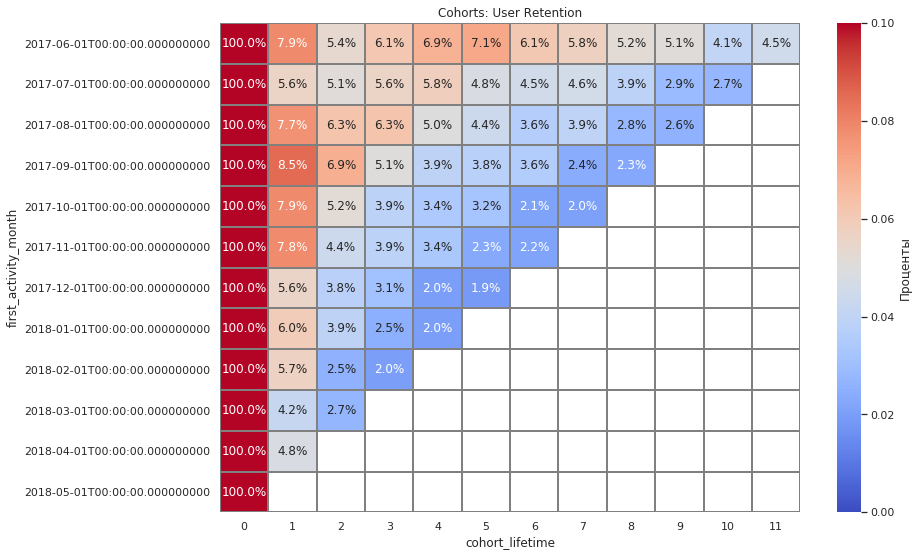

In [83]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, 
            annot=True, 
            linewidths=1, 
            linecolor='gray', 
            cbar_kws=  {'label':'Проценты'}, #  {'format': '%.1f%%'},
            vmax=0.1, vmin=0, 
            fmt='.1%',         
            cmap='coolwarm',); 
plt.show()

In [84]:
cohorts_source3 = cohorts_month.loc[cohorts_month['first_visit_source'] == 3]

In [85]:
cohorts_source3.head()

,start_ts,end_ts,uid,first_visit_month,first_visit_source,activity_week,first_activity_week,cohort_lifetime,first_activity_month,activity_month
5,2017-12-01,2017-12-01,9969694820036681168,2017-12-01,3,2017-11-27,2017-11-27,0,2017-12-01,2017-12-01
11,2017-09-01,2017-09-01,16007536194108375387,2017-09-01,3,2017-08-28,2017-08-28,0,2017-09-01,2017-09-01
17,2017-10-01,2017-10-01,16007536194108375387,2017-09-01,3,2017-09-25,2017-08-28,1,2017-09-01,2017-10-01
23,2017-09-01,2017-09-01,16007536194108375387,2017-09-01,3,2017-08-28,2017-08-28,0,2017-09-01,2017-09-01
29,2017-10-01,2017-10-01,16007536194108375387,2017-09-01,3,2017-09-25,2017-08-28,1,2017-09-01,2017-10-01


In [86]:
cohorts_source3.groupby('first_activity_month')['uid'].agg({'uid':'nunique'}).reset_index()

,first_activity_month,uid
0,2017-06-01,4226
1,2017-07-01,3820
2,2017-08-01,3084
3,2017-09-01,5237
4,2017-10-01,7627
5,2017-11-01,8789
6,2017-12-01,7731
7,2018-01-01,6959
8,2018-02-01,6995
9,2018-03-01,5965


### Метрики электронной коммерции

In [87]:
cohorts.head()

,first_activity_month,cohort_lifetime,uid,cohort_users,retention
0,2017-06-01,0,13259,13259,1.00
1,2017-06-01,1,1043,13259,0.08
2,2017-06-01,2,713,13259,0.05
3,2017-06-01,3,814,13259,0.06
4,2017-06-01,4,909,13259,0.07


#### Исследуйте, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки. Изучать изменение этой метрики во времени необязательно

In [88]:
visits.head()

,device,end_ts,source_id,start_ts,uid,visit_month,first_visit_source,first_visit_month,dif_date,dif_date1
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,4,2017-12-01,18.00,18.00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01,2,2018-02-01,28.00,28.00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,5,2017-07-01,0.00,0.00
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-01,4,2018-03-01,24.00,24.00
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-01,4,2018-03-01,28.00,28.00


In [89]:
orders1 = orders.copy()
orders1.head()

,buy_ts,revenue,uid,first_visit_source,first_visit_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,1,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,3,2017-06-01


In [91]:
orders1.head()

,buy_ts,revenue,uid,first_visit_source,first_visit_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,1,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,3,2017-06-01


In [92]:
cohorts_month['start_ts'].astype('datetime64[M]')

0        2017-12-01
1        2018-02-01
2        2017-07-01
3        2018-05-01
4        2018-03-01
            ...    
792909   2018-04-01
792910   2017-11-01
792911   2017-07-01
792912   2018-03-01
792913   2018-04-01
Name: start_ts, Length: 792914, dtype: datetime64[ns]

In [93]:
orders1['dif'] =  orders1['buy_ts'].astype('datetime64[M]') - orders1['first_visit_month']

In [94]:
orders1['dif'] = orders1['dif']  / np.timedelta64(1, 'D')

In [95]:
orders1['dif'] = orders1['dif'].astype('int') 

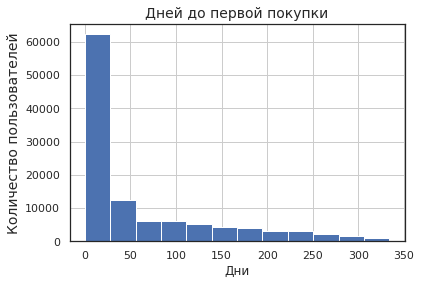

In [96]:
orders1['dif'].hist(bins=12)
plt.xlabel('Дни', fontsize=12)
plt.title('Дней до первой покупки', fontsize=14)
plt.ylabel('Количество пользователей', fontsize=14)
plt.show()

Text(0.5, 0, 'Количество дней')

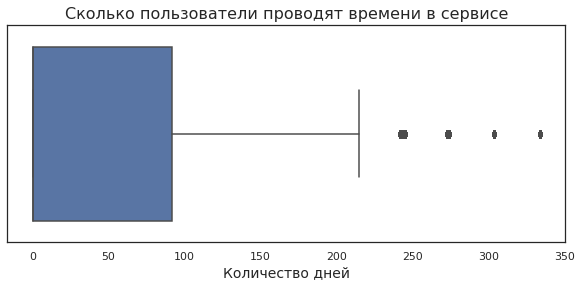

In [97]:
plt.figure(figsize=(10,4))
boxplot = sns.boxplot(x= orders1['dif'] )
boxplot.axes.set_title("Сколько пользователи проводят времени в сервисе", fontsize=16)
boxplot.set_xlabel("Количество дней", fontsize=14)
#boxplot.set_ylabel("Количество", fontsize=14)

Как описывать boxplot?

In [98]:
orders1['dif'].describe()

count   111488.00
mean        55.27
std         85.03
min          0.00
25%          0.00
50%          0.00
75%         92.00
max        334.00
Name: dif, dtype: float64

In [99]:
len(orders1.loc[orders1['dif'] == 0])

62321

In [100]:
len(orders1.loc[orders1['dif'] != 0])

49167

<div class="alert alert-info">
Большинство пользователей совершают покупки в этот же день, оставшиеся думают в среднем  55 дней. 
</div>    

In [101]:
cohorts.head()

,first_activity_month,cohort_lifetime,uid,cohort_users,retention
0,2017-06-01,0,13259,13259,1.00
1,2017-06-01,1,1043,13259,0.08
2,2017-06-01,2,713,13259,0.05
3,2017-06-01,3,814,13259,0.06
4,2017-06-01,4,909,13259,0.07


#### Применяя когортный анализ или другой метод, рассчитайте среднее количество покупок на одного покупателя за определённый период, например за 6 месяцев. Изучать изменение этой метрики во времени необязательно

In [102]:
orders_six_month = orders1

In [103]:
orders_six_month.head()

,buy_ts,revenue,uid,first_visit_source,first_visit_month,dif
0,2017-06-01 00:10:00,17.00,10329302124590727494,1,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,3,2017-06-01,0


In [104]:
orders_six_month['first_visit_month'] = orders_six_month['first_visit_month'].astype(
    'datetime64[M]')
orders_six_month['activity_month'] = orders_six_month['buy_ts'].astype('datetime64[M]')
orders_six_month['cohort_lifetime'] = orders_six_month['activity_month'] - orders1['first_visit_month']

In [105]:
orders_six_month['cohort_lifetime'] = orders_six_month['cohort_lifetime']  / np.timedelta64(1, 'M')
orders_six_month['cohort_lifetime'] = orders_six_month['cohort_lifetime'].round().astype('int') 

In [106]:
orders_six_month.pivot_table(
    index='first_visit_month',
    columns='cohort_lifetime',
    values='uid',
    aggfunc='nunique',
)

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,,
2017-06-01,2023.00,231.00,129.00,188.00,257.00,203.00,189.00,155.00,172.00,156.00,114.00,167.00
2017-07-01,1753.00,135.00,149.00,154.00,153.00,133.00,122.00,128.00,115.00,72.00,75.00,nan
2017-08-01,1208.00,156.00,138.00,117.00,103.00,76.00,76.00,86.00,53.00,58.00,nan,nan
2017-09-01,2257.00,365.00,241.00,178.00,111.00,140.00,140.00,69.00,93.00,nan,nan,nan
2017-10-01,3761.00,476.00,292.00,197.00,198.00,177.00,116.00,123.00,nan,nan,nan,nan
2017-11-01,3357.00,556.00,263.00,183.00,201.00,109.00,129.00,nan,nan,nan,nan,nan
2017-12-01,3491.00,330.00,189.00,187.00,87.00,124.00,nan,nan,nan,nan,nan,nan
2018-01-01,2644.00,320.00,175.00,79.00,90.00,nan,nan,nan,nan,nan,nan,nan
2018-02-01,2852.00,281.00,99.00,106.00,nan,nan,nan,nan,nan,nan,nan,nan


In [107]:
cohorts.head()

,first_activity_month,cohort_lifetime,uid,cohort_users,retention
0,2017-06-01,0,13259,13259,1.00
1,2017-06-01,1,1043,13259,0.08
2,2017-06-01,2,713,13259,0.05
3,2017-06-01,3,814,13259,0.06
4,2017-06-01,4,909,13259,0.07


Среднее количество продаж за период 6 месяцев без выбросов

In [108]:
orders_six_month = orders_six_month.loc[orders['buy_ts'] < '2017-12-01']

In [109]:
orders_six_month.head()

,buy_ts,revenue,uid,first_visit_source,first_visit_month,dif,activity_month,cohort_lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,1,2017-06-01,0,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2,2017-06-01,0,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2,2017-06-01,0,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2,2017-06-01,0,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,3,2017-06-01,0,2017-06-01,0


In [110]:
orders_grouped_by_cohorts = orders_six_month.groupby(
    ['first_visit_month', 'activity_month']
).agg({'revenue': 'sum', 'uid': 'nunique'})

In [111]:
orders_six_month['revenue'].count() / orders_six_month.groupby('uid').agg({'uid': 'nunique'}).sum()

uid   2.74
dtype: float64

In [112]:
cohorts.head()

,first_activity_month,cohort_lifetime,uid,cohort_users,retention
0,2017-06-01,0,13259,13259,1.00
1,2017-06-01,1,1043,13259,0.08
2,2017-06-01,2,713,13259,0.05
3,2017-06-01,3,814,13259,0.06
4,2017-06-01,4,909,13259,0.07


#### Рассчет среднего чека, применяя группировку по времени совершения покупки

In [113]:
orders_AvgCheck = orders1.groupby('activity_month')['revenue'].mean()

In [114]:
orders_AvgCheck

activity_month
2017-06-01    5.74
2017-07-01    5.82
2017-08-01    5.51
2017-09-01    9.40
2017-10-01    6.98
2017-11-01    6.01
2017-12-01   17.33
2018-01-01    6.62
2018-02-01    7.06
2018-03-01    7.19
2018-04-01    8.05
2018-05-01    7.48
2018-06-01    3.42
Name: revenue, dtype: float64

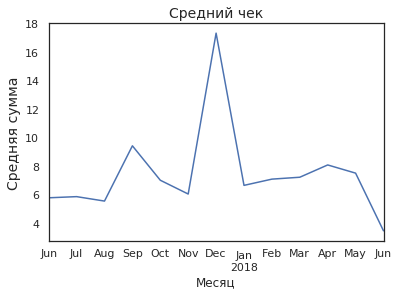

In [115]:
orders_AvgCheck.plot()
plt.xlabel('Месяц', fontsize=12)
plt.title('Средний чек', fontsize=14)
plt.ylabel('Средняя сумма', fontsize=14)
plt.show()

In [116]:
orders_AvgCheck.describe()

count   13.00
mean     7.43
std      3.30
min      3.42
25%      5.82
50%      6.98
75%      7.48
max     17.33
Name: revenue, dtype: float64

Средний "среднего" чека 7.43 С ноября по декбрь средний чек растет, и после нового года падает. Видна сезность в работе сервиса.

#### Как меняется LTV на покупателя по когортам?
LTV — накопительная метрика. Расчет среднего LTV по когортам за 6 месяцев; в расчёт включены когорты, «прожившие» не менее 6 месяцев. Маржинальность сервиса — 100%.

- найти дату первой покупки каждого покупателя;
- вычислить число новых покупателей за каждую дату;
- добавить дату первой покупки в таблицу с заказами;
- сгруппировать таблицу и посчитать выручку.

In [117]:
orders_ltv = orders.copy()
costs_ltv = costs.copy()

In [118]:
orders_ltv['order_month'] = orders_ltv['buy_ts'].astype('datetime64[M]')
#costs_ltv['month'] = costs_ltv['date'].astype('datetime64[M]')

In [119]:
orders_ltv.head()

,buy_ts,revenue,uid,first_visit_source,first_visit_month,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,1,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,3,2017-06-01,2017-06-01


Количество покупателей в каждом месяце. (n_buyers)

In [120]:
cohort_sizes = (
    orders_ltv.groupby(['first_visit_month', 'first_visit_source'])
    .agg({'uid': 'nunique'})
    .reset_index()
)
#cohort_sizes.head()
cohort_sizes.columns = ['first_visit_month', 'first_visit_source', 'n_buyers']
cohort_sizes.head()

,first_visit_month,first_visit_source,n_buyers
0,2017-06-01,1,406
1,2017-06-01,2,513
2,2017-06-01,3,963
3,2017-06-01,4,735
4,2017-06-01,5,594


Посчитаем сколько каждая когорта приносит каждый месяц

In [121]:
cohorts_ltv = (
    orders_ltv.groupby(['first_visit_source', 'first_visit_month', 'order_month'])
    .agg({'revenue': 'sum'})
    .reset_index()
)
cohorts_ltv.head()

,first_visit_source,first_visit_month,order_month,revenue
0,1,2017-06-01,2017-06-01,9623.69
1,1,2017-06-01,2017-07-01,4721.21
2,1,2017-06-01,2017-08-01,2884.57
3,1,2017-06-01,2017-09-01,11811.91
4,1,2017-06-01,2017-10-01,9687.41


In [122]:
margin_rate = 2

LTV — накопительная выручка когорты в пересчёте на количество людей. Добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц:

In [123]:
report = pd.merge(cohort_sizes, cohorts_ltv, on=['first_visit_month', 'first_visit_source'])

In [124]:
report.head()

,first_visit_month,first_visit_source,n_buyers,order_month,revenue
0,2017-06-01,1,406,2017-06-01,9623.69
1,2017-06-01,1,406,2017-07-01,4721.21
2,2017-06-01,1,406,2017-08-01,2884.57
3,2017-06-01,1,406,2017-09-01,11811.91
4,2017-06-01,1,406,2017-10-01,9687.41


In [125]:
report['gp'] = report['revenue'] / margin_rate

In [126]:
report['ltv'] = report['gp'] / report['n_buyers']

In [127]:
report['age'] = (
    report['order_month'] - report['first_visit_month']
) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

In [128]:
result = report.pivot_table(
    index='first_visit_month', columns='age', values='ltv', aggfunc='mean'
).round()

In [129]:
report.head()

,first_visit_month,first_visit_source,n_buyers,order_month,revenue,gp,ltv,age
0,2017-06-01,1,406,2017-06-01,9623.69,4811.84,11.85,0
1,2017-06-01,1,406,2017-07-01,4721.21,2360.60,5.81,1
2,2017-06-01,1,406,2017-08-01,2884.57,1442.28,3.55,2
3,2017-06-01,1,406,2017-09-01,11811.91,5905.95,14.55,3
4,2017-06-01,1,406,2017-10-01,9687.41,4843.71,11.93,4


In [130]:
result.head()

age,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,,
2017-06-01,4.00,2.00,1.00,4.00,5.00,2.00,3.00,4.00,3.00,4.00,4.00,3.00
2017-07-01,3.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan
2017-08-01,3.00,0.00,0.00,1.00,0.00,0.00,0.00,2.00,1.00,0.00,nan,nan
2017-09-01,4.00,1.00,1.00,17.00,1.00,2.00,0.00,0.00,0.00,nan,nan,nan
2017-10-01,3.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,nan,nan


In [131]:
m6_cum_ltv = result.cumsum(axis=1).mean(axis=0)[5] 

In [132]:
print('Средний LTV за 6 месяцев после первой покупки:', m6_cum_ltv)

Средний LTV за 6 месяцев после первой покупки: 9.428571428571429


Теперь получаеться ltv за 6 месяцев 3.4 

### Маркетинговые метрики

Сравним как различаються маркетинговые метрики по рекламным источникам.

Главный первый источник перехода для пользователя

#### Расчет общей суммы расходов на маркетинг. Затраты маркетинга по источникам. Визуализация изменения метрик во времени

In [133]:
costs.head()

,source_id,dt,costs,date
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-02
2,1,2017-06-03,36.53,2017-06-03
3,1,2017-06-04,55.00,2017-06-04
4,1,2017-06-05,57.08,2017-06-05


In [134]:
costs_m = costs

In [135]:
costs_m['cost_month'] = costs_m['dt'].astype('datetime64[M]')

Всего источников маркетинга

In [136]:
costs_m['source_id'].unique()

array([ 1,  2,  3,  4,  5,  9, 10])

In [137]:
print('Общая сумма трат на маркетинг', costs_m['costs'].sum())

Общая сумма трат на маркетинг 329131.62


In [138]:
costs_m.groupby('source_id')['costs'].sum().sort_values(ascending=False)

source_id
3    141321.63
4     61073.60
5     51757.10
2     42806.04
1     20833.27
10     5822.49
9      5517.49
Name: costs, dtype: float64

In [139]:
cost_group = costs_m.groupby(['dt','source_id'])['costs'].sum()

In [140]:
cost_pivot = costs_m.pivot_table(index='cost_month', columns='source_id', values='costs', aggfunc = 'sum')

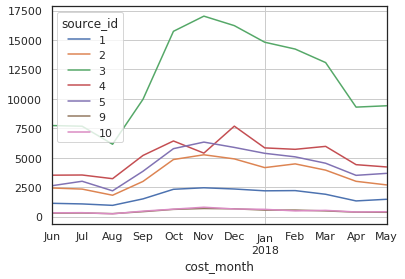

In [141]:
cost_pivot.plot(grid='True')

#### Рассчет среднего CAC на одного покупателя для всего проекта и для каждого источника трафика. Отразите изменения метрик на графиках

In [142]:
visits.head()

,device,end_ts,source_id,start_ts,uid,visit_month,first_visit_source,first_visit_month,dif_date,dif_date1
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,4,2017-12-01,18.00,18.00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01,2,2018-02-01,28.00,28.00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,5,2017-07-01,0.00,0.00
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-01,4,2018-03-01,24.00,24.00
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-01,4,2018-03-01,28.00,28.00


In [143]:
visits1 = visits[['start_ts', 'end_ts', 'device', 'uid', 'first_visit_source', 'first_visit_month']]

In [144]:
visits1.head()

,start_ts,end_ts,device,uid,first_visit_source,first_visit_month
0,2017-12-20 17:20:00,2017-12-20 17:38:00,touch,16879256277535980062,4,2017-12-01
1,2018-02-19 16:53:00,2018-02-19 17:21:00,desktop,104060357244891740,2,2018-02-01
2,2017-07-01 01:54:00,2017-07-01 01:54:00,touch,7459035603376831527,5,2017-07-01
3,2018-05-20 10:59:00,2018-05-20 11:23:00,desktop,16174680259334210214,4,2018-03-01
4,2018-03-09 20:05:00,2018-03-09 20:33:00,desktop,16174680259334210214,4,2018-03-01


In [145]:
report.head()

,first_visit_month,first_visit_source,n_buyers,order_month,revenue,gp,ltv,age
0,2017-06-01,1,406,2017-06-01,9623.69,4811.84,11.85,0
1,2017-06-01,1,406,2017-07-01,4721.21,2360.60,5.81,1
2,2017-06-01,1,406,2017-08-01,2884.57,1442.28,3.55,2
3,2017-06-01,1,406,2017-09-01,11811.91,5905.95,14.55,3
4,2017-06-01,1,406,2017-10-01,9687.41,4843.71,11.93,4


In [146]:
costs_cac = costs[['source_id', 'dt', 'costs']]

In [147]:
costs_cac.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [149]:
costs_cac['month'] = costs_cac['dt'].astype('datetime64[M]')

In [150]:
costs_cac.head()

,source_id,dt,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


Расчет САС для всего проекта

In [151]:
cac_df = pd.DataFrame()

cost_source = []
n_buyers_source = []
cac_source = []

In [152]:
def costing_cac(row):
    
#расходы 
    costs_filter = costs_cac[(costs_cac['source_id'] == row)]['costs'].sum()
    #print("Затраты на маркетинг по источнику {0} составили: {1}".format(1, costs_filter))
    cost_source.append(costs_filter)   
#покупки
    cohort_filter = report.loc[report['first_visit_source'] == row].reset_index()
    
    if len(cohort_filter) > 0:
        n_buyers_filter = cohort_filter['n_buyers'][0]
        #print("Количество покупателей по источнику {0} составили: {1}".format(1, n_buyers_filter))
        n_buyers_source.append(n_buyers_filter)
        cac = costs_filter / n_buyers_filter
        cac_source.append(cac)
        #print("По источнику {0} - CAC = {1:3.2f}".format(1, cac))        
    else:
        #если cohort_filter пусто добавляем ноль
        n_buyers_source.append(0)
        cac_source.append(0)

In [153]:
for row in sources:
    costing_cac(row)

cac_df['source'] = sources
cac_df['cost']   = cost_source
cac_df['buyers'] = n_buyers_source
cac_df['cac']    = cac_source    

In [154]:
cac_df

,source,cost,buyers,cac
0,1,20833.27,406,51.31
1,2,42806.04,513,83.44
2,3,141321.63,963,146.75
3,4,61073.60,735,83.09
4,5,51757.10,594,87.13
5,6,0.00,0,0.00
6,7,0.00,1,0.00
7,9,5517.49,179,30.82
8,10,5822.49,128,45.49


Средниц CAC по все му проекту

In [155]:
avg_cac = cac_df['cost'].sum() / cac_df['buyers'].sum()
print('Средний САС за все время проекта', avg_cac)

Средний САС за все время проекта 93.52987212276214


In [156]:
# считаем расходы за месяц
monthly_costs = costs_cac.groupby(['month', 'source_id']).sum().reset_index()
monthly_costs.columns = ['first_visit_month', 'first_visit_source', 'costs']
monthly_costs.head() 

,first_visit_month,first_visit_source,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12


In [157]:
report_new = report.merge(monthly_costs, how='left')
report_new['cac'] = report_new['costs'] / report_new['n_buyers']

Пересчитал cac по источникам за все время  
Осталось ROMI посчитать в следующем этапе

In [158]:
report_new.head()

,first_visit_month,first_visit_source,n_buyers,order_month,revenue,gp,ltv,age,costs,cac
0,2017-06-01,1,406,2017-06-01,9623.69,4811.84,11.85,0,1125.61,2.77
1,2017-06-01,1,406,2017-07-01,4721.21,2360.60,5.81,1,1125.61,2.77
2,2017-06-01,1,406,2017-08-01,2884.57,1442.28,3.55,2,1125.61,2.77
3,2017-06-01,1,406,2017-09-01,11811.91,5905.95,14.55,3,1125.61,2.77
4,2017-06-01,1,406,2017-10-01,9687.41,4843.71,11.93,4,1125.61,2.77


In [159]:
orders.head()

,buy_ts,revenue,uid,first_visit_source,first_visit_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,1,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,3,2017-06-01


Количество посещений с источников по которым не было покупателей и затрат на маркетинг

In [160]:
visits.loc[visits['source_id'] == 7].shape[0]

37

In [161]:
visits.loc[visits['source_id'] == 6].shape[0]

13

<div class="alert alert-info"> 
Расчитал CAC  по источникам прихода пользователей и общий.
Есть два источника по которым не было покупок и расходов на маркетинг но пользователи приходили по ним. 
Самый доргой источник "3", но и больше всего пользователей пришло по этому каналу 
</div>    

Средний САС по источнику 1 составляет 3.99
Средний САС по источнику 2 составляет 8.54
Средний САС по источнику 3 составляет 12.47
Средний САС по источнику 4 составляет 5.51
Средний САС по источнику 5 составляет 6.27
Средний САС по источнику 6 составляет nan
Средний САС по источнику 10 составляет 4.18


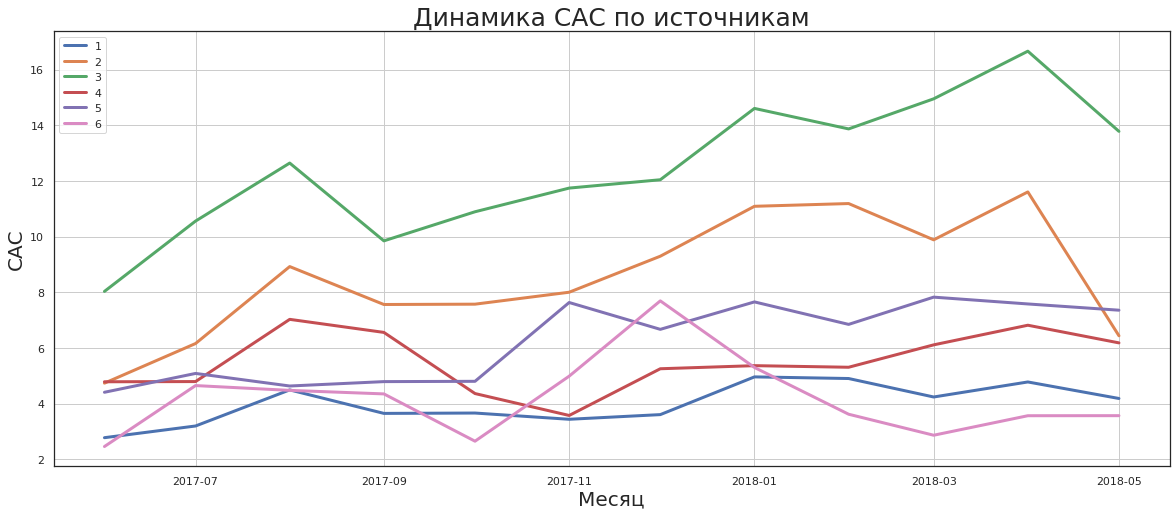

In [162]:
sources = [1, 2,3,4,5,6,10]
def cac_by_source(source):
        # Создаем таблицу с нужным источником, выберем только нужные столбцы чтобы не путаться
    orders_source = orders.loc[orders['first_visit_source'] == source][['uid','first_visit_month']] 
    costs_source = costs.loc[costs['source_id'] == source][['costs', 'cost_month']] 
        # Считаем расходы по месяцам
    costs_per_month_source = costs_source.groupby('cost_month').agg({'costs':'sum'}).reset_index() 
    costs_per_month_source.columns = ['costs_month', 'costs_per_month']
        # Месяц первой покупки
    first_order_source = orders_source.groupby('uid').agg({'first_visit_month':'min'}).reset_index() 
    first_order_source.columns = ['uid','first_order_month']
        # Новые покупатели в каждом месяце
    cohort_sizes_source = first_order_source.groupby('first_order_month').agg({'uid':'nunique'}).reset_index() 
    cohort_sizes_source.columns = ['first_order_month','n_buyers']
        # Объединяем таблицы и считаем САС
    cac_source = cohort_sizes_source.merge(costs_per_month_source, left_on='first_order_month', right_on='costs_month')
    cac_source['cac'] = cac_source['costs_per_month'] / cac_source['n_buyers'] 
    print ('Средний САС по источнику {} составляет {:.2f}'.format(source, cac_source['cac'].mean()))
        # Строим график
    ax=sns.lineplot(data=cac_source, x='first_order_month', y='cac', linewidth = 3) 
    plt.legend(sources)
    ax.axes.set_title('Динамика САС по источникам',fontsize=25)
    ax.set_xlabel('Месяц',fontsize=20)
    ax.set_ylabel('САС',fontsize=20)
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
            
plt.figure(figsize=(20, 8))    
for source in sources:
    cac_by_source(source)

#### Рассчитайте ROMI по когортам в разрезе источников. Сравните окупаемость за одинаковые периоды жизни когорт. Обратите внимание, что клиенты, пришедшие из разных источников, могут иметь разный LTV. Постройте графики, отражающие изменения метрик во времени.

In [164]:
costs_cac.head()

,source_id,dt,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


Перенес в предыдущий этап 

In [165]:
# считаем расходы за месяц
#monthly_costs = costs_cac.groupby(['month', 'source_id']).sum().reset_index()
#monthly_costs.columns = ['first_visit_month', 'first_visit_source', 'costs']
#monthly_costs.head() 
#report_new = report.merge(monthly_costs, how='left')
#report_new['cac'] = report_new['costs'] / report_new['n_buyers']

In [166]:
report_new['romi'] = report_new['ltv'] / report_new['cac']

In [167]:
cac_df.sort_values(by='cac', ascending=False)

,source,cost,buyers,cac
2,3,141321.63,963,146.75
4,5,51757.10,594,87.13
1,2,42806.04,513,83.44
3,4,61073.60,735,83.09
0,1,20833.27,406,51.31
8,10,5822.49,128,45.49
7,9,5517.49,179,30.82
5,6,0.00,0,0.00
6,7,0.00,1,0.00


**Когорта первый источник**

In [168]:
romi_source1 = report_new.loc[report_new['first_visit_source'] == 1].pivot_table(
    index=['first_visit_month'], columns='age', values='romi', aggfunc='mean'
)
romi_source1.cumsum(axis=1).round(2)

age,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,,
2017-06-01,4.27,6.37,7.65,12.90,17.20,20.27,23.61,27.04,30.19,35.51,42.04,47.10
2017-07-01,1.50,1.83,2.00,2.07,2.15,2.24,2.28,2.40,2.57,2.73,2.87,nan
2017-08-01,1.54,1.77,1.84,2.25,2.54,2.72,2.74,5.57,6.95,7.15,nan,nan
2017-09-01,0.98,1.23,1.63,1.80,2.43,2.52,2.54,2.55,2.56,nan,nan,nan
2017-10-01,1.49,2.68,2.81,3.13,3.20,3.25,3.33,3.51,nan,nan,nan,nan
2017-11-01,1.74,1.96,2.01,2.05,2.13,2.16,2.19,nan,nan,nan,nan,nan
2017-12-01,1.00,1.23,1.31,1.42,1.47,1.54,nan,nan,nan,nan,nan,nan
2018-01-01,0.77,1.18,1.35,1.37,1.40,nan,nan,nan,nan,nan,nan,nan
2018-02-01,1.72,2.85,2.93,3.00,nan,nan,nan,nan,nan,nan,nan,nan


**Затраты почти всегда окупаються в первой же месяц.** Первая когорта была очень прибыльной. Возможно клиенты знакомились с с Афишой. По первой когорте можно предположить что есть большой потенциал у первого источника.

**Когорта второй источник**

In [169]:
romi_source2 = report_new.loc[report_new['first_visit_source'] == 2].pivot_table(
    index=['first_visit_month'], columns='age', values='romi', aggfunc='mean'
)
romi_source2.cumsum(axis=1).round(2)

age,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,,
2017-06-01,1.38,2.02,2.27,4.45,7.38,8.16,9.65,11.66,13.04,15.03,16.19,16.66
2017-07-01,0.82,1.18,1.29,1.37,1.43,1.54,1.57,1.61,1.69,1.71,1.80,nan
2017-08-01,0.30,0.34,0.40,0.47,0.50,0.53,0.55,0.63,0.67,0.68,nan,nan
2017-09-01,0.62,1.07,1.27,1.35,1.63,1.74,1.77,1.77,1.78,nan,nan,nan
2017-10-01,0.86,1.16,1.22,1.30,1.33,1.39,1.41,1.43,nan,nan,nan,nan
2017-11-01,0.76,0.92,1.00,1.13,1.19,1.23,1.26,nan,nan,nan,nan,nan
2017-12-01,0.74,1.04,1.83,2.73,2.98,3.24,nan,nan,nan,nan,nan,nan
2018-01-01,0.43,0.58,0.78,0.82,0.88,nan,nan,nan,nan,nan,nan,nan
2018-02-01,0.36,0.63,0.72,0.76,nan,nan,nan,nan,nan,nan,nan,nan


Хороший старт первой когорты, Последующие когорты хуже но окупаються почти все на 2-3 месяц. Возможно на второй источник оказывает большое влияние сезонности. По первой когорте также можно предположить что есть потенциал роста

**Когорта третий источник**

In [170]:
romi_source3 = report_new.loc[report_new['first_visit_source'] == 3].pivot_table(
    index=['first_visit_month'], columns='age', values='romi', aggfunc='mean'
)
romi_source3.cumsum(axis=1).round(2)

age,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,,
2017-06-01,0.24,0.32,0.33,0.38,0.42,0.46,0.50,0.55,0.58,0.60,0.62,0.63
2017-07-01,0.20,0.21,0.23,0.26,0.27,0.28,0.29,0.31,0.32,0.33,0.33,nan
2017-08-01,0.16,0.18,0.19,0.21,0.22,0.23,0.24,0.24,0.25,0.26,nan,nan
2017-09-01,0.23,0.27,0.31,0.32,0.33,0.34,0.36,0.37,0.38,nan,nan,nan
2017-10-01,0.19,0.23,0.24,0.25,0.27,0.28,0.28,0.29,nan,nan,nan,nan
2017-11-01,0.19,0.21,0.22,0.23,0.24,0.25,0.25,nan,nan,nan,nan,nan
2017-12-01,0.18,0.20,0.21,0.21,0.22,0.23,nan,nan,nan,nan,nan,nan
2018-01-01,0.13,0.16,0.17,0.17,0.18,nan,nan,nan,nan,nan,nan,nan
2018-02-01,0.14,0.18,0.19,0.20,nan,nan,nan,nan,nan,nan,nan,nan


Третий источник вообще не окупаеться. Самые большии затраты среди всех представленных источников, также самый дорогой источник в пересчете на пользователя. Но привлек наибольшое количество клиентов. Возможно стоит использовать для продвижения среди пользователей, узнаваемость приложения на рынке. 

**Когорта четвертый источник**

In [171]:
romi_source4 = report_new.loc[report_new['first_visit_source'] == 4].pivot_table(
    index=['first_visit_month'], columns='age', values='romi', aggfunc='mean'
)
romi_source4.cumsum(axis=1).round(2)

age,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,,
2017-06-01,0.53,0.74,0.81,1.27,1.71,1.99,2.52,2.78,2.99,3.27,3.47,3.66
2017-07-01,0.51,0.56,0.59,0.62,0.67,0.69,0.71,0.74,0.77,0.79,0.80,nan
2017-08-01,0.36,0.40,0.42,0.47,0.50,0.53,0.55,0.63,0.65,0.65,nan,nan
2017-09-01,0.35,0.41,0.45,0.48,0.52,0.53,0.56,0.57,0.60,nan,nan,nan
2017-10-01,0.57,0.72,0.77,0.80,0.82,0.85,0.87,0.89,nan,nan,nan,nan
2017-11-01,0.76,0.89,0.93,0.96,1.00,1.02,1.04,nan,nan,nan,nan,nan
2017-12-01,0.42,0.45,0.47,0.49,0.50,0.52,nan,nan,nan,nan,nan,nan
2018-01-01,0.40,0.49,0.51,0.52,0.52,nan,nan,nan,nan,nan,nan,nan
2018-02-01,0.45,0.59,0.62,0.64,nan,nan,nan,nan,nan,nan,nan,nan


Второй источник по стоимости. Первая когорта окупила себя, следующие когорты к концу году могут окупить затраты

**Когорта пятый источник**

In [172]:
romi_source5 = report_new.loc[report_new['first_visit_source'] == 5].pivot_table(
    index=['first_visit_month'], columns='age', values='romi', aggfunc='mean'
)
romi_source5.cumsum(axis=1).round(2)

age,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,,
2017-06-01,0.70,1.06,1.27,1.98,2.87,3.19,3.79,4.23,4.71,5.18,5.37,5.48
2017-07-01,0.63,0.75,0.82,0.84,0.88,0.91,0.93,0.96,0.98,0.99,1.02,nan
2017-08-01,0.54,0.76,0.97,1.15,1.42,1.57,1.66,1.73,1.79,1.85,nan,nan
2017-09-01,2.05,2.11,2.54,26.63,27.74,30.76,31.16,31.46,31.48,nan,nan,nan
2017-10-01,0.58,0.66,0.70,0.73,0.75,0.78,0.79,0.81,nan,nan,nan,nan
2017-11-01,0.35,0.40,0.42,0.43,0.44,0.45,0.46,nan,nan,nan,nan,nan
2017-12-01,0.43,0.46,0.47,0.49,0.50,0.50,nan,nan,nan,nan,nan,nan
2018-01-01,0.35,0.49,0.52,0.53,0.56,nan,nan,nan,nan,nan,nan,nan
2018-02-01,0.37,0.40,0.41,0.41,nan,nan,nan,nan,nan,nan,nan,nan


Два раза за год когорта хорошо окупаеться. в остальном на уровне остальных

**Когорта девятый источник**

In [173]:
romi_source9 = report_new.loc[report_new['first_visit_source'] == 9].pivot_table(
    index=['first_visit_month'], columns='age', values='romi', aggfunc='mean'
)
romi_source9.cumsum(axis=1).round(2)

age,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,,
2017-06-01,0.80,0.87,1.11,1.26,1.65,1.80,1.98,2.06,2.27,2.53,2.59,2.63
2017-07-01,0.73,0.91,1.10,1.28,1.40,1.42,1.52,1.56,1.66,1.70,1.78,nan
2017-08-01,0.52,0.59,0.83,0.98,1.08,1.12,1.24,1.35,1.38,1.41,nan,nan
2017-09-01,0.54,0.76,0.95,1.11,1.21,1.29,1.40,1.58,1.81,nan,nan,nan
2017-10-01,0.50,0.60,0.65,0.70,0.74,0.75,0.78,0.79,nan,nan,nan,nan
2017-11-01,0.64,0.74,0.79,0.85,0.91,0.93,0.95,nan,nan,nan,nan,nan
2017-12-01,0.43,0.51,0.54,0.59,0.60,0.62,nan,nan,nan,nan,nan,nan
2018-01-01,0.21,0.27,0.32,0.32,0.32,nan,nan,nan,nan,nan,nan,nan
2018-02-01,0.24,0.28,0.30,0.34,nan,nan,nan,nan,nan,nan,nan,nan


Первые когорты окупаються но современем окупаемость снижаеться, самый дешевый источник, первые когорты окупаються. Постепенно доходы снижаються

**Когорта десятый источник**

In [174]:
romi_source10 = report_new.loc[report_new['first_visit_source'] == 10].pivot_table(
    index=['first_visit_month'], columns='age', values='romi', aggfunc='mean'
)
romi_source10.cumsum(axis=1).round(2)

age,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,,
2017-06-01,0.53,0.58,0.59,0.64,0.81,0.84,0.90,nan,0.97,1.05,1.10,1.13
2017-07-01,0.34,0.50,0.67,0.71,0.79,0.83,0.86,0.88,0.88,0.89,0.91,nan
2017-08-01,0.75,0.78,0.87,0.87,0.89,nan,0.89,0.90,nan,0.94,nan,nan
2017-09-01,0.25,0.32,0.33,0.36,0.36,0.37,0.39,0.40,0.40,nan,nan,nan
2017-10-01,0.46,0.50,0.52,0.52,0.55,0.60,0.61,0.61,nan,nan,nan,nan
2017-11-01,0.58,0.63,0.64,0.68,0.69,0.70,0.73,nan,nan,nan,nan,nan
2017-12-01,0.26,0.27,0.28,0.29,nan,0.30,nan,nan,nan,nan,nan,nan
2018-01-01,0.26,0.29,0.32,0.33,0.36,nan,nan,nan,nan,nan,nan,nan
2018-02-01,0.35,0.38,0.39,0.40,nan,nan,nan,nan,nan,nan,nan,nan


Второй дешевый источник, летние когорты к концу году окупаються

Средний САС по источнику 1 составляет 3.99
Средний САС по источнику 2 составляет 8.54
Средний САС по источнику 3 составляет 12.47
Средний САС по источнику 4 составляет 5.51
Средний САС по источнику 5 составляет 6.27
Средний САС по источнику 9 составляет 5.41
Средний САС по источнику 10 составляет 4.18


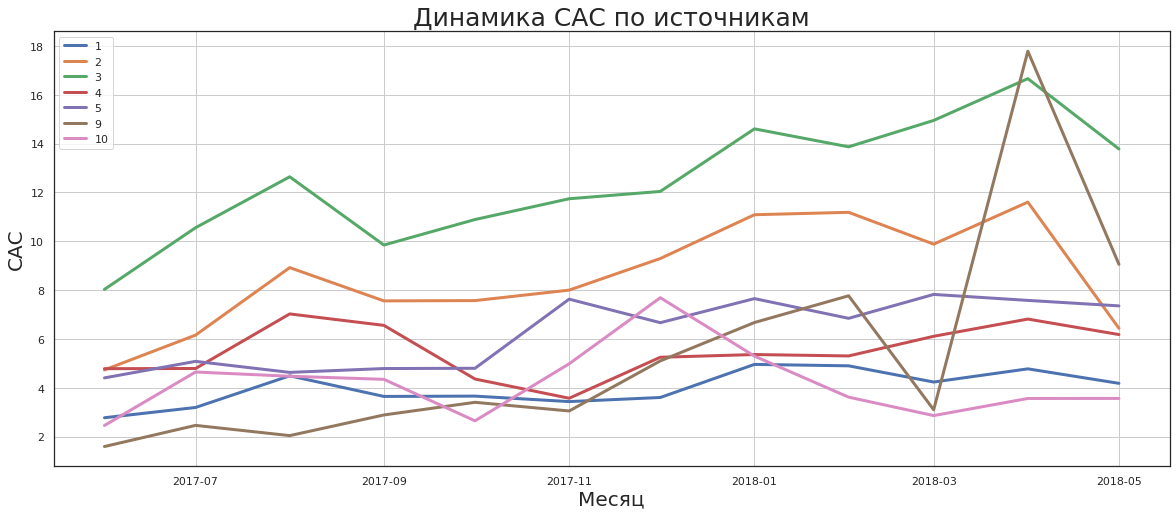

In [175]:
sources = [1, 2,3,4,5,9,10]
def cac_by_source(source):
        # Создаем таблицу с нужным источником, выберем только нужные столбцы чтобы не путаться
    orders_source = orders.loc[orders['first_visit_source'] == source][['uid','first_visit_month']] 
    costs_source = costs.loc[costs['source_id'] == source][['costs', 'cost_month']] 
        # Считаем расходы по месяцам
    costs_per_month_source = costs_source.groupby('cost_month').agg({'costs':'sum'}).reset_index() 
    costs_per_month_source.columns = ['costs_month', 'costs_per_month']
        # Месяц первой покупки
    first_order_source = orders_source.groupby('uid').agg({'first_visit_month':'min'}).reset_index() 
    first_order_source.columns = ['uid','first_order_month']
        # Новые покупатели в каждом месяце
    cohort_sizes_source = first_order_source.groupby('first_order_month').agg({'uid':'nunique'}).reset_index() 
    cohort_sizes_source.columns = ['first_order_month','n_buyers']
        # Объединяем таблицы и считаем САС
    cac_source = cohort_sizes_source.merge(costs_per_month_source, left_on='first_order_month', right_on='costs_month')
    cac_source['cac'] = cac_source['costs_per_month'] / cac_source['n_buyers'] 
    print ('Средний САС по источнику {} составляет {:.2f}'.format(source, cac_source['cac'].mean()))
        # Строим график
    ax=sns.lineplot(data=cac_source, x='first_order_month', y='cac', linewidth = 3) 
    plt.legend(sources)
    ax.axes.set_title('Динамика САС по источникам',fontsize=25)
    ax.set_xlabel('Месяц',fontsize=20)
    ax.set_ylabel('САС',fontsize=20)
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
            
plt.figure(figsize=(20, 8))    
for source in sources:
    cac_by_source(source)

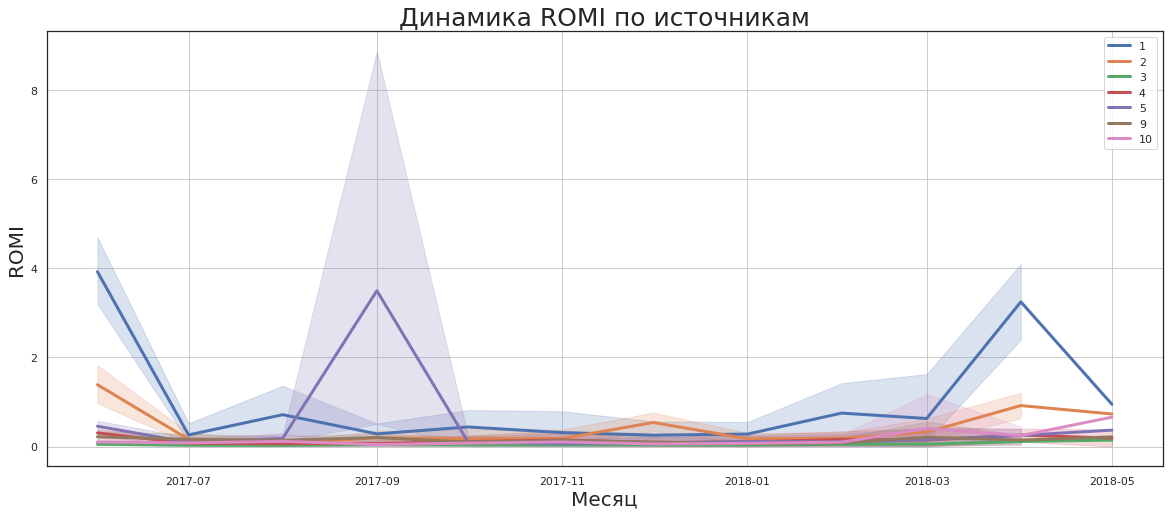

In [176]:
def romi_by_source(source):
    ax=sns.lineplot(
        data=report_new.loc[report_new['first_visit_source'] == source], x='first_visit_month', y='romi', linewidth = 3) 
    plt.legend(sources)
    ax.axes.set_title('Динамика ROMI по источникам',fontsize=25)
    ax.set_xlabel('Месяц',fontsize=20)
    ax.set_ylabel('ROMI',fontsize=20)
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    
plt.figure(figsize=(20, 8))    
for source in sources:
    romi_by_source(source)    

## Выводы и рекомендации

Наша задача в проекте снизить расходы - откзаться от невыгодных источников трафика.
В предоставленных данных 9 источников прихода новых пользователей. Два из них скорее всего новые пользователи только начали приходить покупок они не совершали.
Из остальных сильно выделяються по затратам источник 3. Хотя этот источник и привлек больше всего пользователей но за год окупилась только первая когорта, остальные когорты не и на 50%. **Поэтому возникает вопрос нужен такой источник?**

Варианты перераспределения ресурсов на другие источники.


Источник 1 - все когорты быстро окупились, многие в первый месяц. Возможно источник это концентрация людей интересующихся куда-нибудь пойти. 

Источник 2 - когорты 2017 года тоже быстро окупились. После нового года наблюдаеться спад, но для этого времени это нормально. Стоит обратить на него в следующий сезон 

Источник 5 - Есть потенциал роста, сентябрьская когорта сильно выделяеться по доходам.

Источник 9 и 10 по сравнению с остальными это самые дешевые по стоимости привлечения пользователей. 30.8 и 45.5 соответсвенно

Маркетологам будут интересны все когорты Источника 1 и особенно первая когорта;
Источник 2 первая когорта; Источник 2 первая и четвертая когорты

In [177]:
cac_df.sort_values(by='cac', ascending=False)

,source,cost,buyers,cac
2,3,141321.63,963,146.75
4,5,51757.10,594,87.13
1,2,42806.04,513,83.44
3,4,61073.60,735,83.09
0,1,20833.27,406,51.31
8,10,5822.49,128,45.49
7,9,5517.49,179,30.82
5,6,0.00,0,0.00
6,7,0.00,1,0.00


In [ ]:
def cac_by_source(source):
        # Создаем таблицу с нужным источником, выберем только нужные столбцы чтобы не путаться
    orders_source = orders.loc[orders['main_source'] == source][['uid','buy_month']] 
    costs_source = costs.loc[costs['source_id'] == source][['costs', 'cost_month']] 
        # Считаем расходы по месяцам
    costs_per_month_source = costs_source.groupby('cost_month').agg({'costs':'sum'}).reset_index() 
    costs_per_month_source.columns = ['costs_month', 'costs_per_month']
        # Месяц первой покупки
    first_order_source = orders_source.groupby('uid').agg({'buy_month':'min'}).reset_index() 
    first_order_source.columns = ['uid','first_order_month']
        # Новые покупатели в каждом месяце
    cohort_sizes_source = first_order_source.groupby('first_order_month').agg({'uid':'nunique'}).reset_index() 
    cohort_sizes_source.columns = ['first_order_month','n_buyers']
        # Объединяем таблицы и считаем САС
    cac_source = cohort_sizes_source.merge(costs_per_month_source, left_on='first_order_month', right_on='costs_month')
    cac_source['cac'] = cac_source['costs_per_month'] / cac_source['n_buyers'] 
    print ('Средний САС по источнику {} составляет {:.2f}'.format(source, cac_source['cac'].mean()))
        # Строим график
    ax=sns.lineplot(data=cac_source, x='first_order_month', y='cac', linewidth = 3) 
    plt.legend(sources)
    ax.axes.set_title('Динамика САС по источникам',fontsize=25)
    ax.set_xlabel('Месяц',fontsize=20)
    ax.set_ylabel('САС',fontsize=20)
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
            
plt.figure(figsize=(20, 8))    
for source in sources:
    cac_by_source(source)